# II: Percolation of defects
This notebook contains all the useful computations to make Figures in the 
supplementary informations 

In [1]:
%matplotlib inline
#
from lrgsglib.core import *
from lrgsglib.funcs import create_Lattice2D_WeigvV
from lrgsglib.config.plotlib import ListedColormap
from scipy.optimize import curve_fit
#
move_to_rootf()
plt.style.use("ipynb/nb_plotsheet.mplstyle")
#
subDatPth = os.path.join('plot', 'paper', 'suppinf', '')
datPth = os.path.join('data', subDatPth)
subPthStr = ['anderson_localization', 'defects_plots']
datPthDict = {s: os.path.join(datPth, s, '') for s in subPthStr}
for path in datPthDict.values(): os.makedirs(path, exist_ok=True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Anderson localization

In [2]:
pflip = 0.15
side1 = 64

In [3]:
l = Lattice2D(side1, pflip=pflip, seed=363)
l.flip_sel_edges(l.fleset['G'])
l.compute_k_eigvV()

In [4]:
arr = l.eigV[0].reshape(*l.syshape)
compound_log_array = np.log(np.abs(arr))
compound_log_array2 = np.where(arr > 0, np.log(arr), np.nan)

/tmp/ipykernel_337032/276624561.py:3: RuntimeWarning: invalid value encountered in log
  compound_log_array2 = np.where(arr > 0, np.log(arr), np.nan)


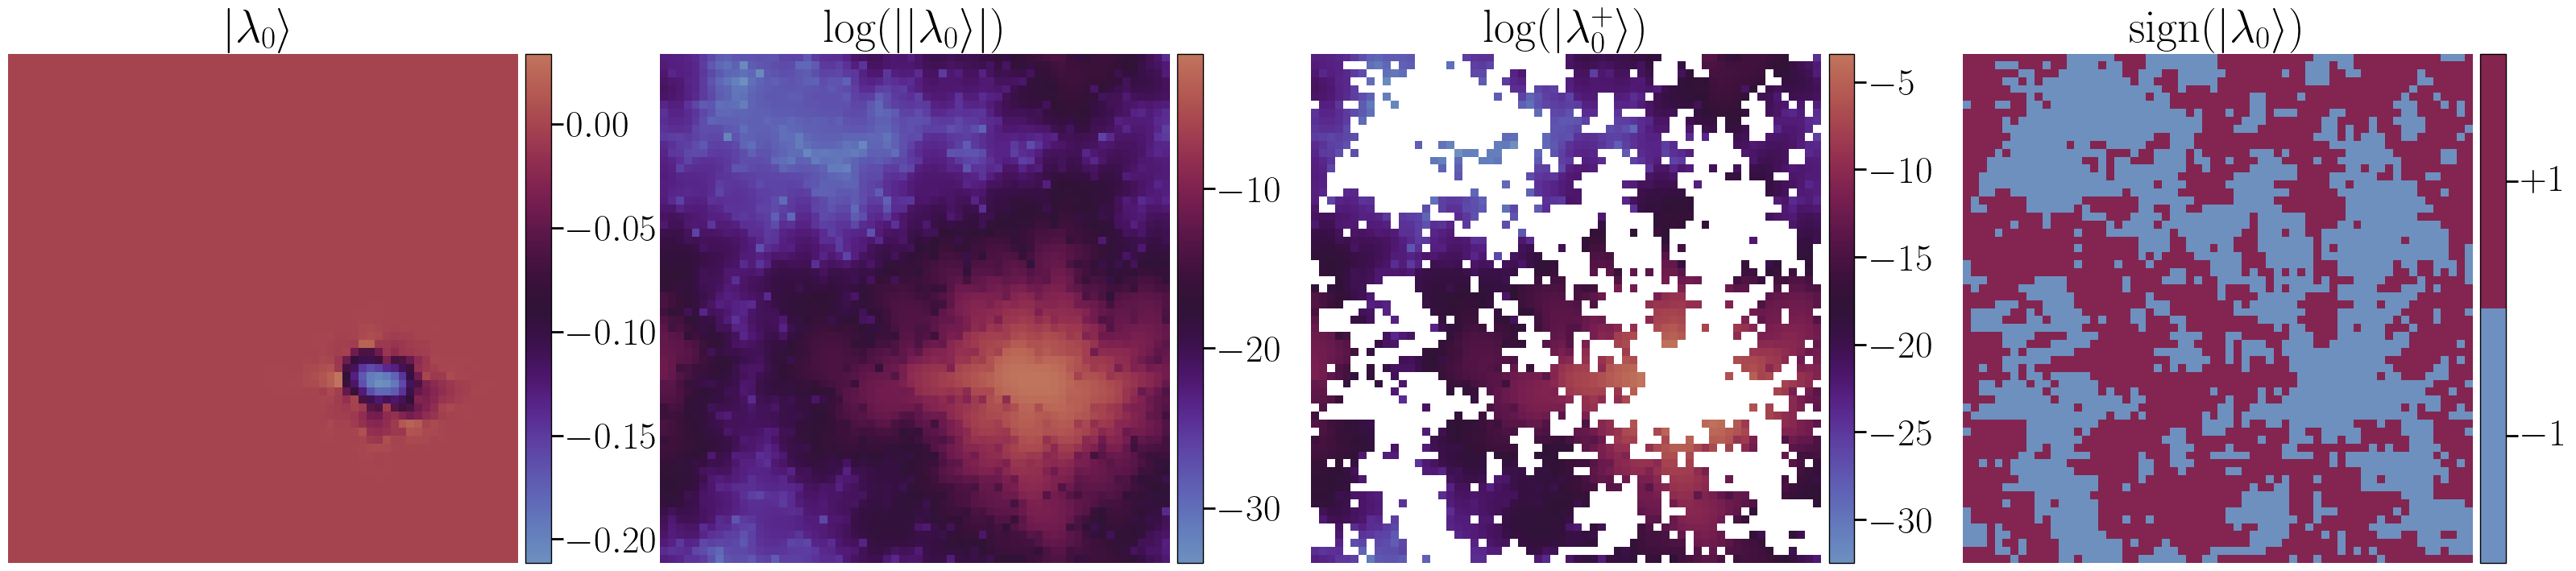

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10))
#
kwim = dict(pad=0.1)
kwimshow = dict(cmap=restr_twilight, interpolation='none')
#
im = ax1.imshow(arr, **kwimshow)
ax1.set_title(r"$|\lambda_0\rangle$")
imshow_colorbar_caxdivider(im, ax1, **kwim)
im = ax2.imshow(compound_log_array, **kwimshow)
ax2.set_title(r"$\log(\abs{|\lambda_0\rangle})$")
imshow_colorbar_caxdivider(im, ax2, **kwim)
im = ax3.imshow(compound_log_array2, **kwimshow)
ax3.set_title(r"$\log(|\lambda_0^+\rangle)$")
imshow_colorbar_caxdivider(im, ax3, **kwim)
im = ax4.imshow(l.bin_eigV().reshape(*l.syshape), cmap=credcblu)
ax4.set_title(r"$\mathrm{sign}(|\lambda_0\rangle)$")
_, _, clb = imshow_colorbar_caxdivider(im, ax4, **kwim)
tick_positions = [-.5, .5]
# Set labels corresponding to the tick positions
tick_labels = [r'$-1$', r'$+1$']
# Apply the tick positions and labels
clb.set_ticks(tick_positions)
clb.set_ticklabels(tick_labels)
for label in clb.ax.get_yticklabels():
    label.set_verticalalignment('center')
for ax in (ax1, ax2, ax3, ax4):
    ax.axis('off')
#
fig.savefig(os.path.join(datPthDict['anderson_localization'], 
                         f"p={pflip:.3g}_{l.seed}.pdf"), bbox_inches="tight")
plt.close('all')

## Single sinks

### 3D
Fit of $\psi(r) = C_1/r + C_2$ on the single link defect

In [ ]:
sizes3d = [25, 50, 100, 150]
cmap = restr_twilight#
colors = cmap(np.linspace(0, 1, len(sizes3d)))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
def model_1r(x, C_1, C_2):
    return C_2*(1-C_1/(np.abs(x)*C_2))

In [ ]:
dict_plot3D = {}
for s in sizes3d:
    l3 = Lattice3D(s)
    l3.flip_sel_edges([l3.get_central_edge()])
    l3.compute_k_eigvV()
    #
    field = np.abs(l3.eigV[0].reshape(*l3.syshape))
    cut = np.s_[:, l3.dim[1]//2, l3.dim[2]//2]
    x3 = np.linspace(-l3.dim[0]//2, l3.dim[0]//2, num=l3.dim[0])
    x3_cont = np.linspace(np.min(x3), np.max(x3), num=10000)
    #
    f_x3 = field[cut]/np.min(field[cut])
    dict_plot3D[s] = [np.round(x3, 1), f_x3]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8*1.5, 6*1.5))
kw3dplot = dict(lw=2, marker='h', ms=12)
for s in sizes3d:
    line, = ax.plot(dict_plot3D[s][0] + (1 if s==25 else 0), dict_plot3D[s][1], zorder=1/np.abs(s), 
                    label = f"${s**3}$", **kw3dplot)
    line.set_markerfacecolor(set_alpha_torgb(line.get_color(), 0.75))

x3 = dict_plot3D[sizes3d[-1]][0]
f_x3 = dict_plot3D[sizes3d[-1]][1]
popt3D, pcov3D = curve_fit(model_1r, x3, f_x3)
fit3D = model_1r(x3_cont, *popt3D)
x3_cont = x3_cont[np.abs(x3_cont)>.5]
fit3D = model_1r(x3_cont, *popt3D)
ax.plot(x3_cont, fit3D, 'r-', lw=2.5, label='fit $C_1/r + C_2$')
ax.legend(fontsize=26)
ax.set_xscale('symlog')
fig.savefig(os.path.join(datPthDict['defects_plots'],"3D.pdf"), 
            bbox_inches="tight")

### 2D

In [ ]:
sizes2d = [32, 64, 256, 512]
cmap = restr_twilight#
colors = cmap(np.linspace(0, 1, len(sizes2d)))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
def model_log(x, a, b, c):
    return a*np.log(np.abs(x)+c)+b

In [ ]:
dict_plot2D = {}
for s in sizes2d:
    l2 = Lattice2D(s, init_nw_dict=True)
    l2.flip_sel_edges(l2.nwDict['single']['G'])
    l2.compute_k_eigvV()
    #
    field = np.abs(l2.eigV[0].reshape(*l2.syshape))
    cut = np.s_[:,l2.side1//2]
    x2 = np.linspace(-l2.side1//2, l2.side1//2, num=l2.side1)-1
    x2 = np.rint(x2)
    x2 = np.concatenate([x2[x2<0]+1, x2[x2>=0]])
    #
    f_x2 = field[cut]/np.min(field[cut])
    dict_plot2D[s] = [x2, f_x2]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8*1.5, 6*1.5))
kw2dplot = dict(lw=2, marker='h', ms=12)
for s in sizes2d:
    line, = ax.plot(dict_plot2D[s][0]+.5, dict_plot2D[s][1], zorder=1/np.abs(s), 
                    label = f"${s**3}$", **kw3dplot)
    line.set_markerfacecolor(set_alpha_torgb(line.get_color(), 0.75))

x2 = dict_plot2D[sizes2d[-1]][0]+.5
f_x2 = dict_plot2D[sizes2d[-1]][1]
popt2D, pcov2D = curve_fit(model_log, x2, f_x2)
x2_cont = np.linspace(np.min(x2), np.max(x2), num=10000)
x2_cont = x2_cont[np.abs(x2_cont)>.5]
fit2D = model_log(x2_cont, *popt2D)
ax.plot(x2_cont, fit2D, 'r-', lw=2.5, label=r'fit $C_1\log(r+C_2) + C_3$')
ax.legend(fontsize=24)
ax.set_xscale('symlog')
fig.savefig(os.path.join(datPthDict['defects_plots'],"2D.pdf"), 
            bbox_inches="tight")

## Map to continuum percolation

In [ ]:
side = 96
geo = 'squared'
cell = 'rand'
#
randpList = [0.05, 0.10, 0.25]
#
cmap = ListedColormap([cred, cblu])
#
start_letter = 'a'  # Change this to start from a different letter
total_subplots = 3
alphabet = string.ascii_lowercase
start_index = alphabet.index(start_letter.lower())
labels = [fr"\textbf{{({alphabet[(start_index + i) % 26]})}}" 
          for i in range(total_subplots)]

In [ ]:
thezip = zip(randpList, labels)
for pflip, ll in thezip:
    l = create_Lattice2D_WeigvV(cell=cell, side1=side, geo='squared', 
                                pflip=pflip, pbc=False, 
                                init_nw_dict=True, with_positions=True)
    #
    fig, ax = plt.subplots(ncols=2)
    #
    ticks = [0, side-1]
    ticksl = [r'$1$', fr'${side}$']
    #
    arr = flip_to_positive_majority_adapted(l.bin_eigV().reshape(l.syshape))
    im = ax[0].imshow(np.rot90(arr), cmap=cmap, 
                        origin='upper', interpolation='none')
    #
    ax[0].set_xticks(ticks)
    ax[0].set_yticks(ticks)
    ax[0].set_xticklabels(ticksl)
    ax[0].set_yticklabels(ticksl)
    #
    divdr, caxm, cbar = imshow_colorbar_caxdivider(im, ax[0])
    cbar.set_ticks([])
    #
    (x_txt, y_txt) = -0.15, 1.05
    ax[0].text(x_txt, y_txt, ll,
                transform=ax[0].transAxes, fontsize=50, 
                ha='center', va='center'
    )
    #
    ax[1].set_aspect('equal')
    #
    kwargsNxDraw = dict(width=1, node_size=0)
    nx.draw(l.G, l.get_node_pos(), ax[1], 
            edge_color=l.get_edge_color(pec='none'), **kwargsNxDraw)
    radius = np.sqrt(l.eta_c/(np.pi*2*l.p_c))
    circles = [tuple([i[0][0], i[0][1]+.5]) 
            if (i[0][1] == i[1][1] - 1) 
            else tuple([i[0][0]+.5, i[0][1]]) 
            for i in l.fleset['H']]
    nodeAll = set(circles)
    lCl = find_largest_cluster_circle2D(circles, radius)
    ndOther = nodeAll - set(lCl)
    for cc in nodeAll:
        circC = (cc[0], cc[1])
        col = 'k' if circC in ndOther else 'r'
        circle = plt.Circle(circC, radius, 
                            color=col, alpha=.25)
        ax[1].add_patch(circle)
    fname = f'suppli_defcomp_{geo}_{side}_{pflip}_{cell}.pdf'
    fig.savefig(os.path.join(datPthDict['defects_plots'], fname), 
        bbox_inches='tight', transparent=True)
    plt.close('all')

In [ ]:
side = 96
geo = 'squared'
#
randZpList = [0.05, 0.10, 0.25]
randXpList = [0.10, 0.25, 0.50]
#
cmap = ListedColormap([cred, cblu])
#
start_letter = 'a'  # Change this to start from a different letter
total_subplots = 3
alphabet = string.ascii_lowercase
start_index = alphabet.index(start_letter.lower())
labels = [fr"\textbf{{({alphabet[(start_index + i) % 26]})}}" for i in range(total_subplots)]

In [ ]:
for cell in ['rand', 'randZERR', 'randXERR']:
    match cell:
        case 'rand' | 'randZERR':
            thezip = zip(randZpList, labels)
        case 'randXERR':
            thezip = zip(randXpList, labels)
    for pflip, ll in thezip:
        l = create_Lattice2D_WeigvV(cell=cell, side1=side, geo='squared', 
                                    pflip=pflip, pbc=False, 
                                    init_nw_dict=True, with_positions=True)
        #
        fig, ax = plt.subplots(ncols=2)
        #
        ticks = [0, side-1]
        ticksl = [r'$1$', fr'${side}$']
        #
        arr = flip_to_positive_majority_adapted(l.bin_eigV().reshape(l.syshape))
        im = ax[0].imshow(np.rot90(arr), cmap=cmap, 
                          origin='upper', interpolation='none')
        #
        ax[0].set_xticks(ticks)
        ax[0].set_yticks(ticks)
        ax[0].set_xticklabels(ticksl)
        ax[0].set_yticklabels(ticksl)
        #
        divdr, caxm, cbar = imshow_colorbar_caxdivider(im, ax[0])
        cbar.set_ticks([])
        #
        (x_txt, y_txt) = -0.15, 1.05
        ax[0].text(x_txt, y_txt, ll,
                   transform=ax[0].transAxes, fontsize=50, 
                   ha='center', va='center'
        )
        #
        ax[1].set_aspect('equal')
        #
        match cell:
            case 'rand' | 'randZERR':
                kwargsNxDraw = dict(width=1, node_size=0)
                nx.draw(l.G, l.get_node_pos(), ax[1], 
                        edge_color=l.get_edge_color(pec='none'), **kwargsNxDraw)
                if cell == 'rand':
                    radius = np.sqrt(l.eta_c/(np.pi*2*l.p_c))
                elif cell == 'randZERR':
                    radius = l.r_c
                match cell:
                    case 'rand':
                        circles = [tuple([i[0][0], i[0][1]+.5]) 
                                if (i[0][1] == i[1][1] - 1) 
                                else tuple([i[0][0]+.5, i[0][1]]) 
                                for i in l.fleset['H']]
                        nodeAll = set(circles)
                    case 'randZERR':
                        circles = np.array(l.nwDict.rNodeFlip['H'])
                        nodeAll = set(l.nwDict.rNodeFlip['H'])
                        ndOther = nodeAll - set(lCl)
                lCl = find_largest_cluster_circle2D(circles, radius)
                ndOther = nodeAll - set(lCl)
                match cell:
                    case 'rand':
                        for cc in nodeAll:
                            circC = (cc[0], cc[1])
                            col = 'k' if circC in ndOther else 'r'
                            circle = plt.Circle(circC, radius, 
                                                color=col, alpha=.25)
                            ax[1].add_patch(circle)
                    case 'randZERR':
                        for cc in nodeAll:
                            circC = (cc[0]-.5, cc[1]-.5)
                            col = 'k' if cc in ndOther else 'r'
                            circle = plt.Circle(circC, radius, 
                                                color=col, alpha=.25)
                            ax[1].add_patch(circle)
            case 'randXERR':
                l.load_eigV_on_g()
                kwargsNxDraw = dict(width=2, edgecolors='black', node_size=0)
                nx.draw(l.G, l.get_node_pos(), ax[1],
                    edge_color=l.get_edge_color(pec='none'), **kwargsNxDraw)
        fname = f'suppli_DEF_{geo}_{side}_{pflip}_{cell}.pdf'
        fig.tight_layout()
        fig.savefig(os.path.join(datPthDict['defects_plots'], fname), 
            bbox_inches='tight', transparent=True)
        plt.close('all')

## RSB

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(5*4, 5))
pflip = [0.001, 0.05, 0.15, 0.5]
for i,pflip in enumerate(pflip):
    l = Lattice2D(128, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    ll = l.eigv/l.eigv[0]
    ax[i].hist(ll, bins=100, density=True)
    ax[i].set_xlabel(r'${\lambda}/{\lambda_0}$')
ax[0].set_ylabel(r'$P(\frac{\lambda}{\lambda_0})$')
fig.tight_layout()
fig.savefig(os.path.join(datPthDict['anderson_localization'], 'spectra_histo.pdf'), 
            bbox_inches='tight')

Text(0, 0.5, '$P({\\lambda})$')

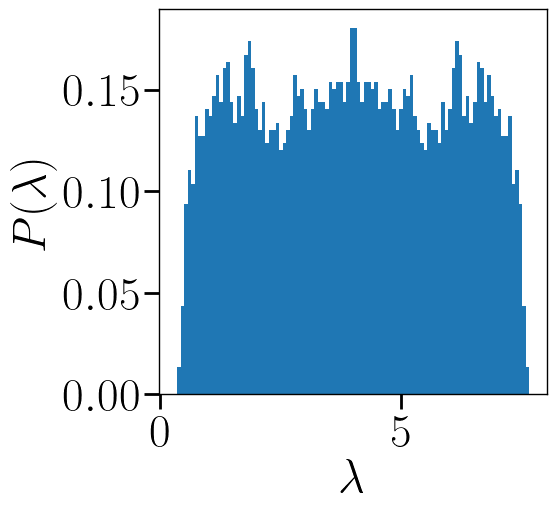

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pflip = [0.2]
for i,pflip in enumerate(pflip):
    l = Lattice2D(64, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    ll = l.eigv
    ax.hist(ll, bins=100, density=True)
    ax.set_xlabel(r'${\lambda}$')
ax.set_ylabel(r'$P({\lambda})$')
# fig.tight_layout()
# fig.savefig(os.path.join(datPthDict['anderson_localization'], 'spectra_histo.pdf'), 
#             bbox_inches='tight')
# plt.yscale('log')
# plt.xscale('log')

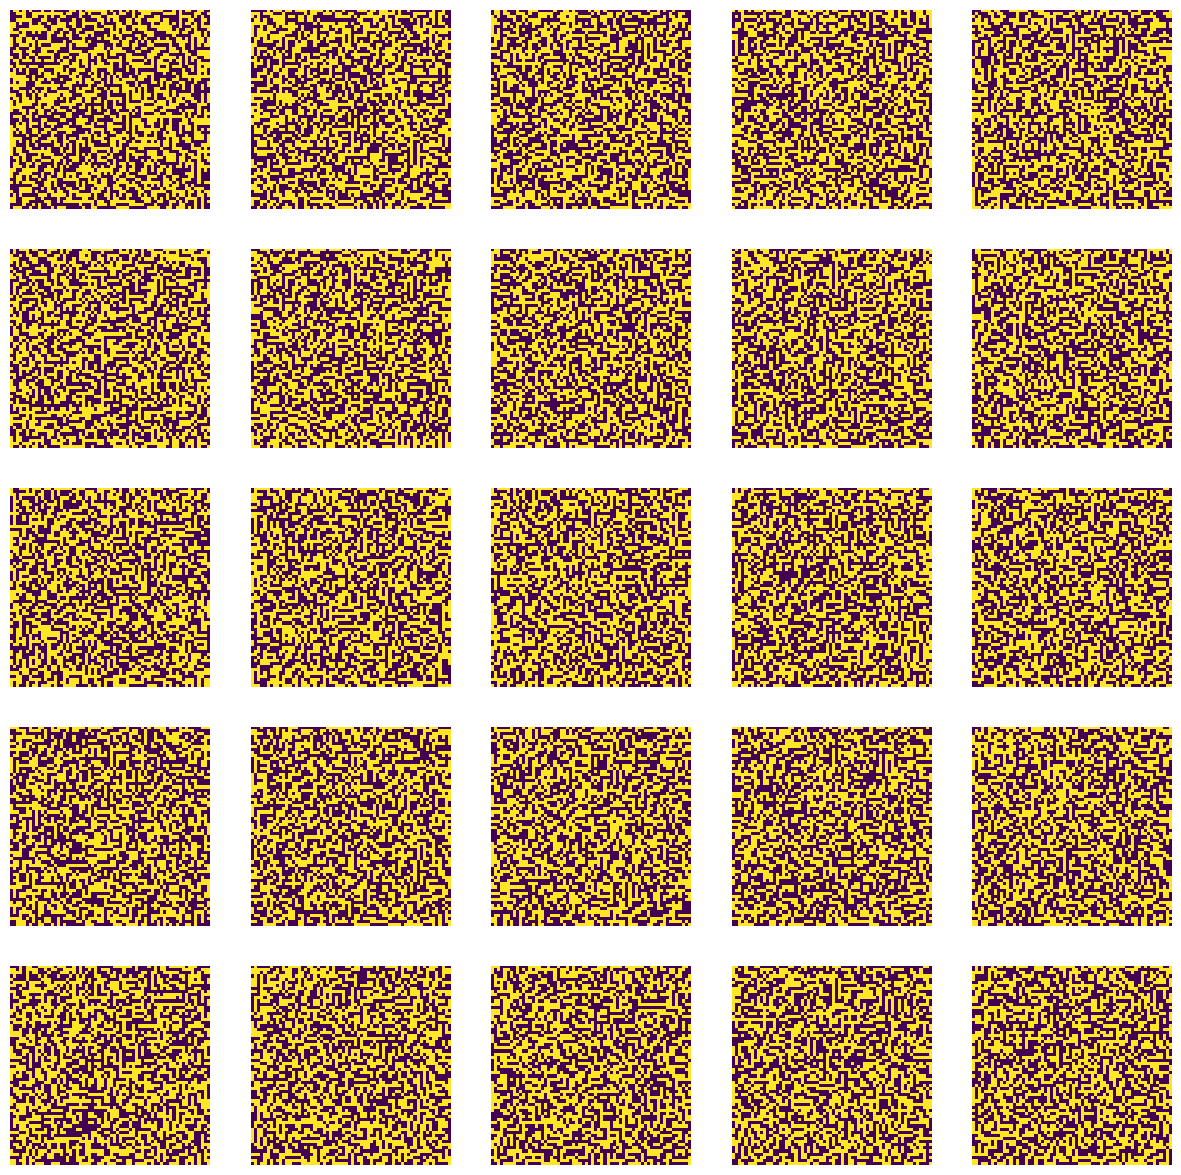

In [42]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
pflip = 0.2
l = Lattice2D(64, pflip=pflip)
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='numpy')
count = -1
for i in range(5):
    for j in range(5):
        count +=1
        ax[i][j].imshow(np.sign(l.eigV[l.N//2-1-count].reshape(*l.syshape)))
        ax[i][j].axis('off')

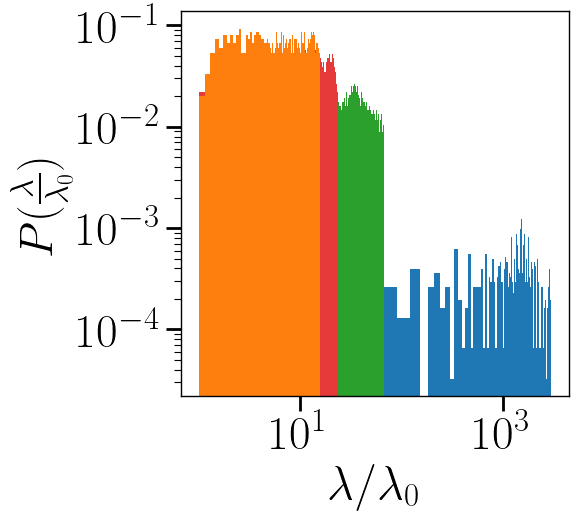

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pflip = [0.001, 0.05, 0.15, 0.5]
for i,pflip in enumerate(pflip):
    l = Lattice2D(32, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    ll = l.eigv/l.eigv[0]
    ax.hist(ll, bins=100, density=True)
    ax.set_xlabel(r'${\lambda}/{\lambda_0}$')
ax.set_ylabel(r'$P(\frac{\lambda}{\lambda_0})$')
# fig.tight_layout()
# fig.savefig(os.path.join(datPthDict['anderson_localization'], 'spectra_histo.pdf'), 
#             bbox_inches='tight')
plt.yscale('log')
plt.xscale('log')

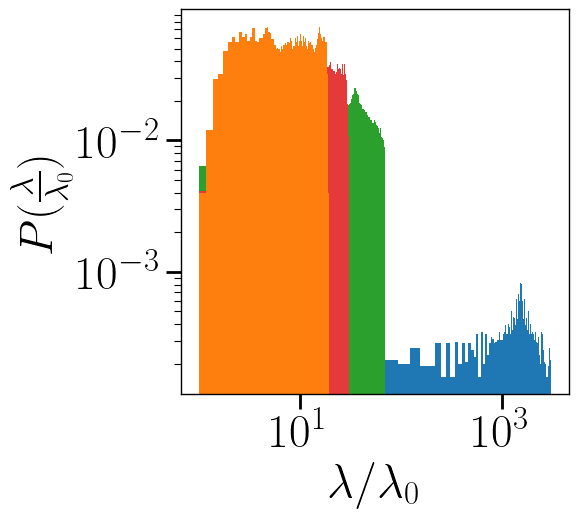

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pflip = [0.001, 0.05, 0.15, 0.3, 0.5]
for i,pflip in enumerate(pflip):
    l = Lattice2D(64, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    ll = l.eigv/l.eigv[0]
    ax.hist(ll, bins=100, density=True)
    ax.set_xlabel(r'${\lambda}/{\lambda_0}$')
ax.set_ylabel(r'$P(\frac{\lambda}{\lambda_0})$')
# fig.tight_layout()
# fig.savefig(os.path.join(datPthDict['anderson_localization'], 'spectra_histo.pdf'), 
#             bbox_inches='tight')
plt.yscale('log')
plt.xscale('log')

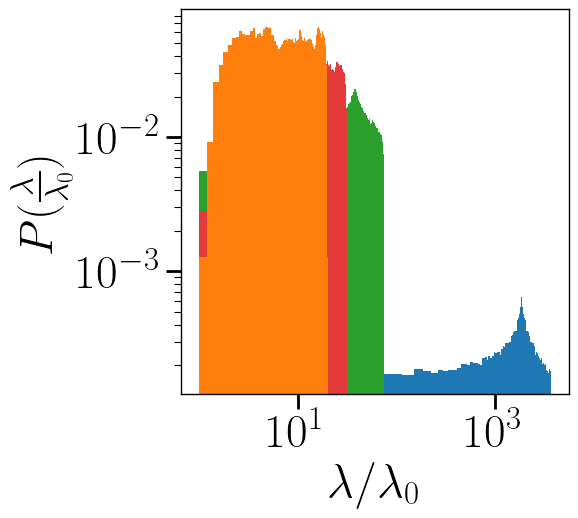

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pflip = [0.001, 0.05, 0.15, 0.5]
for i,pflip in enumerate(pflip):
    l = Lattice2D(128, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='numpy')
    ll = l.eigv/l.eigv[0]
    ax.hist(ll, bins=100, density=True)
    ax.set_xlabel(r'${\lambda}/{\lambda_0}$')
ax.set_ylabel(r'$P(\frac{\lambda}{\lambda_0})$')
# fig.tight_layout()
# fig.savefig(os.path.join(datPthDict['anderson_localization'], 'spectra_histo.pdf'), 
#             bbox_inches='tight')
plt.yscale('log')
plt.xscale('log')

(array([  2.,   8.,  23.,  50.,  66.,  74.,  86.,  95., 107., 111., 120.,
        114., 133., 125., 118., 120., 126., 117., 135., 126., 138., 114.,
        120., 123., 126., 120., 120., 130., 142., 135., 142., 137., 133.,
        136., 127., 123., 121., 115., 109., 101., 100., 100.,  99.,  93.,
         97., 101., 103., 102., 113., 109., 108., 113., 113., 106., 112.,
        107., 117., 112., 111., 111., 108., 117., 106., 107., 106., 107.,
        114., 112., 110., 111., 110., 114., 116., 123., 136., 136., 123.,
        116., 114., 110., 111., 110., 112., 114., 107., 106., 107., 106.,
        117., 108., 111., 111., 112., 117., 107., 112., 106., 113., 113.,
        108., 109., 113., 102., 103., 101.,  97.,  93.,  99., 100., 100.,
        101., 109., 115., 121., 123., 127., 136., 133., 137., 142., 135.,
        142., 130., 120., 120., 126., 123., 120., 114., 138., 126., 135.,
        117., 126., 120., 118., 125., 133., 114., 120., 111., 107.,  95.,
         86.,  74.,  66.,  50.,  23., 

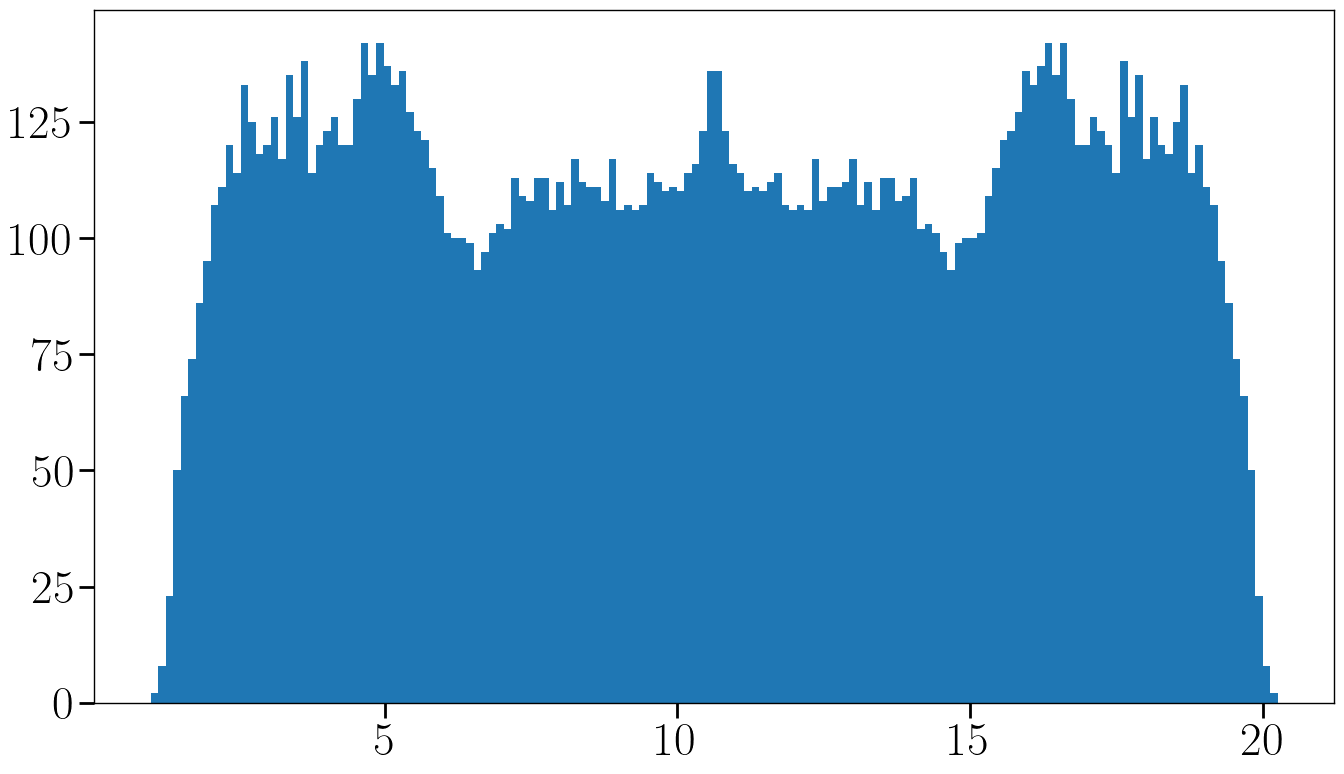

In [17]:
plt.hist(ll, bins=150)
# plt.xscale('log')


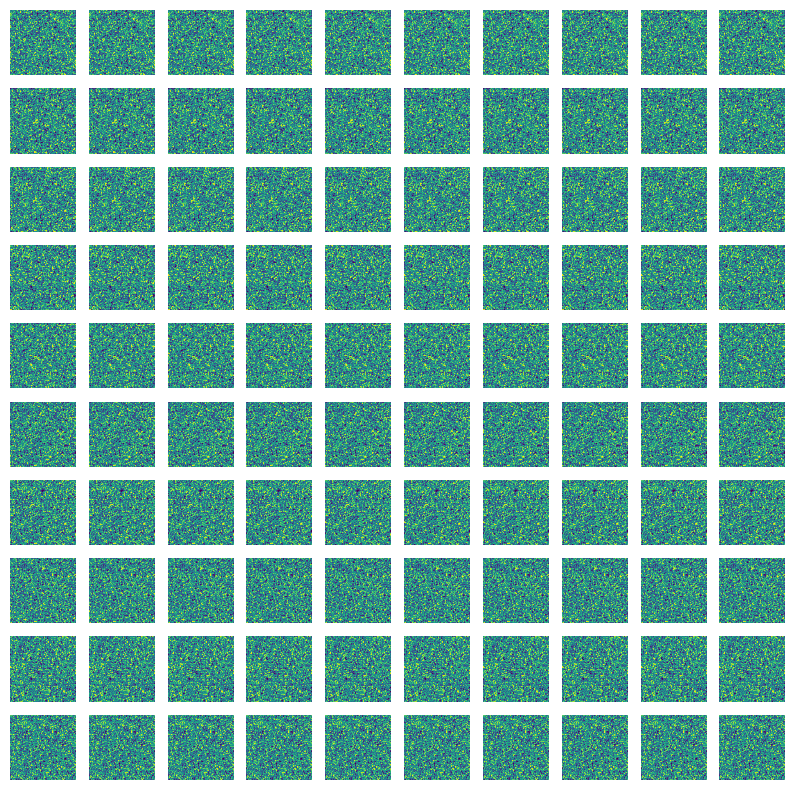

In [29]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(np.sign(l.eigV[i].reshape(*l.syshape)))
        ax[i][j].axis('off')

In [ ]:
plt.

# Trash

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming a 1D grid of size 200
size = 200
# Example 1D field 'phi' (this can be replaced by your actual data)
phi = fx_ss  # Example density field

# Fourier Transform of the 1D field 'phi'
phi_ft = np.fft.fft(phi)

# Shift zero-frequency component to the center
phi_ft_shifted = np.fft.fftshift(phi_ft)

# Upsampling factor
factor = 4  # Increase resolution by a factor of 4
n_new = size * factor
pad_size = (n_new - size) // 2

# Zero-pad in the frequency domain
phi_ft_padded = np.pad(phi_ft_shifted, (pad_size, pad_size), mode='constant')

# Shift back the zero-frequency component to the original place
phi_ft_padded_shifted = np.fft.ifftshift(phi_ft_padded)

# Inverse Fourier Transform to get the upsampled field in the spatial domain
phi_upsampled = np.fft.ifft(phi_ft_padded_shifted).real

# Define the new grid, but keep the same physical size [0, size]
x_new = np.linspace(-size//2, size//2, n_new)

# Plot the original and upsampled field
plt.figure(figsize=(12, 6))

popt_log, pcov_log = curve_fit(model_log, x, phi)
x_cont = np.linspace(np.min(x), np.max(x), num=10000)
fit_log = model_log(x_cont, *popt_log)

plt.subplot(1, 2, 1)
plt.plot(x, phi, label="Original", marker='o')
plt.plot(x_cont, fit_log, ls='-', marker='', label="Upsampled")
plt.xscale('symlog')

plt.grid(True)


xnewidx = x_new>=0
xnewfit = x_new[xnewidx]
popt_log, pcov_log = curve_fit(model_Cio, xnewfit, phi_upsampled[xnewidx])
x_cont = np.linspace(np.min(x_new), np.max(x_new), num=10000)
fit_log = model_Cio(xnewfit, *popt_log)

plt.subplot(1, 2, 2)
plt.plot(x_new+.4, phi_upsampled, label="Upsampled", marker='.')
plt.plot(xnewfit, fit_log, ls='-', marker='', label="Upsampled")
plt.xscale('symlog')
plt.grid(True)
plt.axvline(-1.86)
plt.axvline(1.86)


plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a 200x200 grid
size = 200
x = np.linspace(0, size, size)  # Original grid along x-axis
y = np.linspace(0, size, size)  # Original grid along y-axis
X, Y = np.meshgrid(x, y)

# Example density field 'phi' (this can be replaced by your actual data)
phi = field  # Example density field

# Fourier Transform of phi
phi_ft = np.fft.fft2(phi)

# Shift zero-frequency component to the center
phi_ft_shifted = np.fft.fftshift(phi_ft)

# New grid size after upsampling
factor = 4  # Upsampling factor
n_new = size * factor
pad_size = (n_new - size) // 2

# Zero-pad in the frequency domain
phi_ft_padded = np.pad(phi_ft_shifted, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant')

# Shift back the zero-frequency component to the original place
phi_ft_padded_shifted = np.fft.ifftshift(phi_ft_padded)

# Inverse Fourier Transform to get the upsampled field in the spatial domain
phi_upsampled = np.fft.ifft2(phi_ft_padded_shifted).real

# Define the new grid, but keep the same physical size [0, size]
x_new = np.linspace(0, size, n_new)
y_new = np.linspace(0, size, n_new)
X_new, Y_new = np.meshgrid(x_new, y_new)

# Plot the original and upsampled field
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Field (200x200)")
plt.contourf(X, Y, phi, cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title(f"Upsampled Field ({n_new}x{n_new})")
plt.contourf(X_new, Y_new, phi_upsampled, cmap='viridis')
plt.colorbar()

plt.show()

In [ ]:
phi[cut].max(), phi_upsampled[cut2].max()

In [ ]:
cut2 = np.s_[:, l.side1]
x_cont = np.linspace(np.min(x), np.max(x), num=len(phi_upsampled[cut2]))+.75
popt_log, pcov_log = curve_fit(model_log, x_cont, phi_upsampled[cut2])
fit_log = model_log(x_cont, *popt_log)
plt.plot(x_cont, phi_upsampled[cut2])
plt.plot(x, phi[cut]/10)
plt.plot(x_cont, fit_log, '-', label='Fit fx_log')

plt.xscale('symlog')